# AARRR

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from pyecharts.charts import Funnel
import pyecharts.options as opts

In [2]:
data = pd.read_csv('userbehavior.csv')
data.dropna(inplace=True)
data['datetime'] = pd.to_datetime(data['datetime'],format='%Y/%m/%d %H:%M:%S')
data['date'] = data['datetime'].dt.date
data['time'] = data['datetime'].dt.time
data['hour_of_day'] = data['datetime'].dt.hour
data['weekday'] = data['datetime'].dt.weekday
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')
df = data.loc[data['date']>='2017-11-25']
df = df.loc[data['date']<'2017-12-04']
df.head()

,user_id,item_id,category_id,behavior_type,timestamps,datetime,date,time,hour_of_day,weekday
0,1,2333346,2520771,pv,1.511562e+09,2017-11-25 06:15:33,2017-11-25,06:15:33,6,5
1,1,2576651,149192,pv,1.511573e+09,2017-11-25 09:21:25,2017-11-25,09:21:25,9,5
2,1,3830808,4181361,pv,1.511593e+09,2017-11-25 15:04:53,2017-11-25,15:04:53,15,5
3,1,4365585,2520377,pv,1.511596e+09,2017-11-25 15:49:06,2017-11-25,15:49:06,15,5
4,1,4606018,2735466,pv,1.511616e+09,2017-11-25 21:28:01,2017-11-25,21:28:01,21,5


## Acquisition

In [3]:
pv_day = df[df['behavior_type'] == 'pv'].groupby('date').count()[['behavior_type']]
uv_day = df[df['behavior_type']=='pv'].drop_duplicates(['user_id','date']).groupby('date').count()[['user_id']]
result1 = pd.merge(pv_day,uv_day,on='date')
result1['pv/uv'] = result1['behavior_type']/result1['user_id']
result1.columns = ['pv_day','uv_day','pv/uv']
result1.head()

,pv_day,uv_day,pv/uv
date,,,
2017-11-25,354563,25944,13.666474
2017-11-26,364554,26377,13.820905
2017-11-27,341435,26098,13.082803
2017-11-28,338412,26138,12.947127
2017-11-29,349892,26578,13.164723


(array([736658., 736659., 736660., 736661., 736662., 736663., 736664.,
        736665., 736666.]),
 <a list of 9 Text xticklabel objects>)

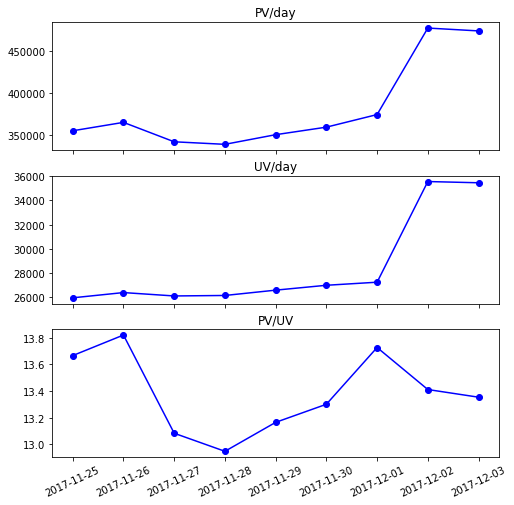

In [4]:
f,[ax1,ax2,ax3] = plt.subplots(3,1,figsize=(8,8),sharex=True)
ax1.plot(result1.index,result1['pv_day'],'bo-')
ax1.set_title('PV/day')
ax2.plot(result1.index,result1['uv_day'],'bo-')
ax2.set_title('UV/day')
ax3.plot(result1.index,result1['pv/uv'],'bo-')
ax3.set_title('PV/UV')
plt.xticks(rotation=25)

## Activation

### 时活跃用户数

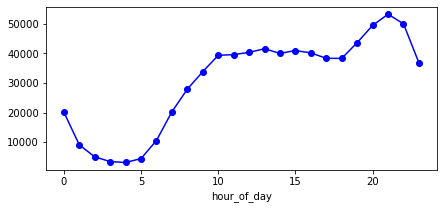

In [8]:
AU_h = df.drop_duplicates(['user_id','hour_of_day','date']).groupby('hour_of_day')['user_id'].count()
plt.figure(figsize=(7,3))
AU_h.plot(color='b',marker='o')

### 日活跃用户数

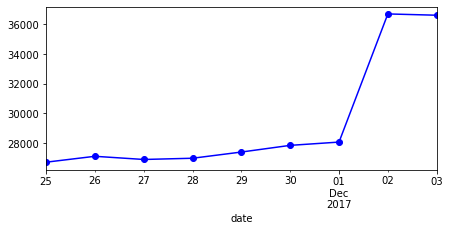

In [9]:
AU_d = df.drop_duplicates(['user_id','date']).groupby('date')['user_id'].count()
plt.figure(figsize=(7,3))
AU_d.plot(color='b',marker='o')

## Retention

### 次日用户留存率

In [10]:
day1_userid = df.loc[df['date']=='2017-11-25'].drop_duplicates('user_id')['user_id'].to_list()
day2_userid = []
list_day2 = df.loc[df['date']=='2017-11-26'].drop_duplicates('user_id')['user_id'].to_list()
for i in list_day2:
    if i in day1_userid:
        day2_userid.append(i)
len(day2_userid)/len(day1_userid)*100

78.88805690752527

### 三日用户留存率

In [11]:
day3_userid = []
list_day3 = df.loc[df['date']=='2017-11-27'].drop_duplicates('user_id')['user_id'].to_list()
for i in list_day3:
    if i in day1_userid:
        day3_userid.append(i)
len(day3_userid)/len(day1_userid)*100

76.98614751029577

### 七日用户留存率

In [12]:
day7_userid = []
list_day7 = df.loc[df['date']=='2017-12-01'].drop_duplicates('user_id')['user_id'].to_list()
for i in list_day7:
    if i in day1_userid:
        day7_userid.append(i)
len(day7_userid)/len(day1_userid)*100

77.540247098465

## Revenue

### 用户购买行为数据漏斗图

In [81]:
pv_users = df.loc[df['behavior_type'] == 'pv'].count()['user_id']
cart_users = df.loc[df['behavior_type'] == 'cart'].count()['user_id']
fav_users = df.loc[df['behavior_type'] == 'fav'].count()['user_id']
buy_users = df.loc[df['behavior_type'] == 'buy'].count()['user_id']
behavior_t= ['PV', 'CART', 'FAV', 'BUY']
values = [np.around((pv_users / pv_users * 100), 2),
         np.around((cart_users / pv_users * 100), 2),
         np.around((fav_users / pv_users * 100), 2),
         np.around((buy_users / pv_users * 100), 2)]
funnel = (
Funnel(init_opts=opts.InitOpts(width="1000px", height="500px")).add(
    series_name=''
    ,data_pair=[*(zip(behavior_t,values))]
    ,gap=2
    ,tooltip_opts=opts.TooltipOpts(formatter="{b}:{c}%")
    ,label_opts=opts.LabelOpts(is_show=True, position="inside"))
    .set_global_opts(title_opts=opts.TitleOpts(title="用户行为转化漏斗图"))
    .render('funnel_chart.html')
)

### 用户复购率

In [13]:
total_buy = df.loc[df['behavior_type']=='buy'].groupby('user_id').count()[['behavior_type']]
total_buy_2 =total_buy.loc[total_buy['behavior_type']>1]
len(total_buy_2)/len(total_buy)*100

65.79527559055119

# 分析及建议

分析：  
--经查询2017年淘宝天猫活动表得知12月1日至12月6日为服饰焕新活动，11.23至11.27为咖啡节，11.27至11.29为火拼周。当进入服饰活动时，流量明显上升，说明客户对服饰类消费倾向更高。
--从12月1日到12月2日，pv和uv都上升，但pv/uv下降，经计算pv的上涨率为27.6%，uv的上涨率为30.6%，pv的涨幅没有uv高，说明访问深度减少，跳失率增加，在做活动的时候是可解释的，用户被优惠卷或价格吸引而点击却没有深度浏览的意向。若进一步分析商品或商品类别，可分析出哪些商品在活动周具有较高的跳失率。

建议：  
--进一步对服饰类的商品进行细分，例如哪些商品为用户访问深度较高的商品，那些为跳出率较高的商品，访问深度高的对内容进行强调，跳出率高的进一步分析例如评论等原因做优化。再例如针对不同的目标客户群划分专场，例如儿童服饰，女士服装等，让用户定位更容易。
通过对时活跃用户书的分析发现晚上8点左右为用户最为活跃时段，此时段要优化首页展示，提升转化率。

拓展分析（本次分析未呈现）：  
--哪类商品用户倾向于先加购物车观望，哪类商品用户倾向于收藏，哪类商品用户倾向于直接购买，倾向于收藏的用户对该类商品有更深的访问深度的倾向，可用智能推荐系统推荐更多的社群，从而增加用户对此类商品的了解，种草。倾向于直接购买的商品可用优惠券来进一步增加浏览到付款的转化率。


# 参考
https://www.cnblogs.com/colin1314/p/11227770.html  
https://zhuanlan.zhihu.com/p/120087230  
https://blog.csdn.net/fei347795790/article/details/98620124  